# Model design

Two qubits that evolve with the same Lindbladian (or different ones, it can come in a jnp.array where the first axis is the number of components)

There should be a way of check errors in jax, but I do not know. Probably try catch before calling something with jit

I guess that the main loop can be done with jit, but before we could check that everything is correct. 

For now let's focus on writing things modular.

1. Write everything in row based vectorization to make it compatible with flat and reshape
2. Work as much as we can with vectorized version
3. 

In [1]:
import jax
import jax.numpy as jnp
from qdots_qll.models.game import *

import qutip as qt

In [2]:
seed = 3
rho_ex = qt.rand_dm_ginibre(2, seed=seed)

In [3]:
print(rho_ex)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.9193551 +0.j         0.06815597+0.09741774j]
 [0.06815597-0.09741774j 0.0806449 +0.j        ]]


In [4]:
qt.tensor([qt.rand_dm_ginibre(2, seed=seed), qt.rand_dm_ginibre(3, seed=seed)])

Quantum object: dims = [[2, 3], [2, 3]], shape = (6, 6), type = oper, isherm = True
Qobj data =
[[ 0.38788866+0.j          0.02818244+0.10552207j  0.20733463-0.16244769j
   0.02875595+0.04110189j -0.00909216+0.01080913j  0.03258412+0.00992684j]
 [ 0.02818244-0.10552207j  0.17207868+0.j         -0.08802428-0.1626816j
   0.01327074-0.00483653j  0.01275697+0.01823399j  0.01071261-0.02138765j]
 [ 0.20733463+0.16244769j -0.08802428+0.1626816j   0.35938776+0.j
  -0.00184281+0.03401281j -0.02376389+0.002733j    0.02664305+0.03808185j]
 [ 0.02875595-0.04110189j  0.01327074+0.00483653j -0.00184281-0.03401281j
   0.0340252 +0.j          0.00247214+0.00925629j  0.01818718-0.01424975j]
 [-0.00909216-0.01080913j  0.01275697-0.01823399j -0.02376389-0.002733j
   0.00247214-0.00925629j  0.01509457+0.j         -0.0077214 -0.01427027j]
 [ 0.03258412-0.00992684j  0.01071261+0.02138765j  0.02664305-0.03808185j
   0.01818718+0.01424975j -0.0077214 +0.01427027j  0.03152513+0.j        ]]

In [5]:
qt.tensor([rho_ex, rho_ex])

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.8452138 +0.j          0.06265954+0.0895615j   0.06265954+0.0895615j
  -0.00484498+0.0132792j ]
 [ 0.06265954-0.0895615j   0.0741413 +0.j          0.01413545+0.j
   0.00549643+0.00785624j]
 [ 0.06265954-0.0895615j   0.01413545+0.j          0.0741413 +0.j
   0.00549643+0.00785624j]
 [-0.00484498-0.0132792j   0.00549643-0.00785624j  0.00549643-0.00785624j
   0.0065036 +0.j        ]]

In [6]:
from qbism import sic_povm

In [7]:
sic_povm(4)

[Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.05897908+0.j         -0.04847955+0.00434903j  0.        +0.02442994j
    0.07290949+0.05463006j]
  [-0.04847955-0.00434903j  0.04016985+0.j          0.00180143-0.02008089j
   -0.0559017 -0.05028098j]
  [ 0.        -0.02442994j  0.00180143+0.02008089j  0.01011921+0.j
    0.02262851-0.0302001j ]
  [ 0.07290949-0.05463006j -0.0559017 +0.05028098j  0.02262851+0.0302001j
    0.14073186+0.j        ]],
 Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
 Qobj data =
 [[ 0.05897908+0.j          0.00434903+0.04847955j  0.        -0.02442994j
   -0.05463006+0.07290949j]
  [ 0.00434903-0.04847955j  0.04016985+0.j         -0.02008089-0.00180143j
    0.0559017 +0.05028098j]
  [ 0.        +0.02442994j -0.02008089+0.00180143j  0.01011921+0.j
   -0.0302001 -0.02262851j]
  [-0.05463006-0.07290949j  0.0559017 -0.05028098j -0.0302001 +0.02262851j
    0.14073186+0.j        ]],
 Quan

In [8]:
import jax.typing

In [9]:
dir(jax.typing)

['ArrayLike',
 'DTypeLike',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [10]:
import equinox as eqx

In [11]:
from jax import Array

# from jax.typing import ArrayLike
from jaxtyping import Array, Float, Complex, Int


class base_class_dimension(eqx.Module):
    d: int
    matrix_d: Float[Array, "d d"]
    positive_eps: Float

    def __init__(
        self,
        dimension: int,
    ) -> None:
        self.d = dimension
        self.matrix_d = jnp.ones([self.d, self.d])
        self.positive_eps = 1e-8

    @jit
    def vec(self, rho: Complex[Array, "d d"]) -> Complex[Array, "d**2"]:
        return rho.flatten()

    @jit
    def sprepost(
        self, A: Complex[Array, "d1 d2"], B: Complex[Array, "d3 d4"]
    ) -> Float[Array, "d1*d2 d2*d4"]:
        return jnp.kron(A, B.T)

    @jit
    def spre(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        return self.sprepost(A, jnp.identity(self.matrix_d.shape[0]))

    @jit
    def spost(self, A: Complex[Array, "d d"]) -> Complex[Array, "d**2 d**2"]:
        return self.sprepost(jnp.identity(self.matrix_d.shape[0]), A)

In [12]:
vec(rho_ex.full()).reshape(2, 2)

array([[0.9193551 +0.j        , 0.06815597+0.09741774j],
       [0.06815597-0.09741774j, 0.0806449 +0.j        ]])

In [13]:
a = base_class_dimension(2)
a.spre(rho_ex.full())

Array([[0.9193551 +0.j        , 0.        +0.j        ,
        0.06815597+0.09741774j, 0.        +0.j        ],
       [0.        +0.j        , 0.9193551 +0.j        ,
        0.        +0.j        , 0.06815597+0.09741774j],
       [0.06815597-0.09741774j, 0.        +0.j        ,
        0.0806449 +0.j        , 0.        +0.j        ],
       [0.        +0.j        , 0.06815597-0.09741774j,
        0.        +0.j        , 0.0806449 +0.j        ]], dtype=complex64)

In [14]:
np.array(sic_povm(4)).shape

(16, 4, 4)

In [195]:
check_nan = jax.jit(
    lambda a: jax.lax.cond(jnp.isnan(a), lambda a: 0.0, lambda a: a, a)
)


@jit
def compute_P_superop(
    evolved_state_vec: Complex[Array, "d**2"],
    POVM_element_vec: Complex[Array, "d**2"],
):

    return check_nan(
        jnp.real(jnp.dot(dag(POVM_element_vec), evolved_state_vec))
    )


@jit
def compute_P_matrix_ver(
    evolved_state: Complex[Array, "d d"],
    POVM_element: Complex[Array, "d d"],
):

    return check_nan(jnp.real(jnp.trace(evolved_state @ POVM_element)))


class single_qdot(base_class_dimension):
    number_of_parameters: int
    delta: float
    Omega: float
    system_hamiltonian: Complex[Array, "d d"]
    A: Complex[Array, "d d"]
    POVM_arr: Complex[Array, "no_outcomes d d"]
    basis_elements: jax.Array
    # true_parameters: jax.Array

    def __init__(self, POVM_array: Complex[Array, "no_outcomes d d"]):
        super().__init__(dimension=2)
        self.number_of_parameters = 4
        self.delta = 0.12739334807998307
        self.Omega = 0.5
        self.system_hamiltonian = self.make_system_hamiltonian()
        self.A = jnp.array([[1, 0], [0, 0]])
        self.POVM_arr = POVM_array
        self.basis_elements = jnp.identity(4)

    @jit
    def make_system_hamiltonian(self) -> Complex[Array, "d d"]:
        return jnp.array([[self.delta, self.Omega / 2], [self.Omega / 2, 0]])

    @jit
    def make_liouvillian(
        self, particle: Float[Array, "number_of_parameters"]
    ) -> Complex[Array, "d**2 d**2"]:
        gn, gp, Sn, Sp = particle
        Snot = -self.delta
        gnot = (
            self.positive_eps
        )  # This is approx to zero. if we write zero derivatives explodes
        # because this appears in square roots d/dx (sqrt) prop to 1/sqrt

        U = jnp.linalg.eigh(self.system_hamiltonian)[1]
        Aij = U @ self.A @ dag(U)
        Cp = 0.5 * gp + 1j * Sp
        Cn = 0.5 * gn + 1j * Sn
        Cnot = 0.5 * gnot + 1j * Snot

        Gamma = jnp.array([[Cnot, Cn], [Cp, Cnot]])

        sqrtgamma = jnp.sqrt(jnp.real(Gamma))

        L = jnp.multiply(Aij, sqrtgamma)

        Af = jnp.multiply(Aij, jnp.conjugate(Gamma))
        Hrenorm = -1j / 2 * (Aij @ dag(Af) - Af @ dag(Aij))

        Htotal = U @ self.system_hamiltonian @ dag(U) + Hrenorm
        Liouvillian_ebasis = (
            -1j * (self.spre(Htotal) - self.spost(Htotal))
            + self.sprepost(dag(L), L)
            - 0.5 * (self.spre(L @ dag(L)) + self.spost(L @ dag(L)))
        )
        return (
            self.sprepost(U, dag(U))
            @ Liouvillian_ebasis
            @ dag(self.sprepost(U, dag(U)))
        )

    @jit
    def evolve_initial_state_liouvillian(
        self,
        t: Float,
        liouvillian: Complex[Array, "d**2 d**2"],
        initial_state: Complex[Array, "d**2"],
    ) -> Complex[Array, "d**2"]:
        # Ltimest = np.einsum("i, jk", times, np.array(Liouvillian_ebasis))
        return expm(t * liouvillian) @ initial_state

    @jit
    def likelihood_particle(
        self,
        particle: Float[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "no_outcomes"]:
        liouvillian = self.make_liouvillian(particle)
        evolved_state_vec = self.evolve_initial_state_liouvillian(
            t, liouvillian, initial_state
        )
        evolved_state_mat = (evolved_state_vec).reshape(self.matrix_d.shape)
        probability = jax.vmap(compute_P_matrix_ver, in_axes=(None, 0))(
            evolved_state_mat, self.POVM_arr
        )
        return probability

    @jit
    def fim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:
        p_array = self.likelihood_particle(particle, t, initial_state)

        jacobian = jax.jacobian(self.likelihood_particle, 0)(
            particle, t, initial_state
        )

        example_zero_matrix = jnp.zeros([particle.shape[0], particle.shape[0]])

        # return jnp.einsum("ij, ik, i -> jk", jacobian, jacobian, 1 / p_array)
        fim_element = jax.vmap(lambda x, p: jnp.outer(x, x) / p)(
            jacobian, p_array
        )
        return jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

        # return (
        #     jax.vmap(
        #         lambda partial_alfa_partial_beta_pi, pi: (
        #             jax.lax.cond(
        #                 jnp.isclose(jnp.abs(pi), self.positive_eps),
        #                 lambda pi, partial_alfa_partial_beta_pi: 0
        #                 * example_zero_matrix,
        #                 lambda pi, partial_alfa_partial_beta_pi: jnp.einsum(
        #                     "i, j-> ij",
        #                     partial_alfa_partial_beta_pi,
        #                     partial_alfa_partial_beta_pi,
        #                 )
        #                 / pi,
        #                 *[pi, partial_alfa_partial_beta_pi]
        #             )
        #         ),
        #         in_axes=(0, 0),
        #     )(jacobian, p_array)
        # ).sum(axis=0)

    @jit
    def generate_data(
        self,
        key: Int[Array, "2"],
        true_particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Int[Array, "1"]:
        probabilities = self.likelihood_particle(
            true_particle, t, initial_state
        )
        probabilities = probabilities / probabilities.sum()
        no_of_outcomes = self.POVM_arr.shape[0]
        outcome = jax.random.choice(
            key, a=jnp.arange(no_of_outcomes), p=probabilities
        )
        return outcome

    @jit
    def qfim(
        self,
        particle: Complex[Array, "number_of_parameters"],
        t: Float,
        initial_state: Complex[Array, "d**2"],
    ) -> Float[Array, "number_of_parameters number_of_parameters"]:

        d = self.matrix_d.shape[0]
        no_parameters = particle.shape[0]

        L = self.make_liouvillian(particle)
        evolved_state = self.evolve_initial_state_liouvillian(
            t, L, initial_state
        ).reshape(d, d)

        eigvals, eigvecs = jnp.linalg.eigh(evolved_state)

        partial_rhoi_parameterj = jax.jacobian(
            lambda particle: self.evolve_initial_state_liouvillian(
                t, self.make_liouvillian(particle), initial_state
            ),
            holomorphic=True,
        )(particle.astype(jnp.complex64)).T.reshape(
            no_parameters, d, d
        )  # first index is related to the parameter

        denominator_lambda_i_plus_lambda_j = jax.vmap(
            lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
        )(eigvals)

        braket = jnp.einsum(
            "im,amn,jn-> ija",
            jnp.conjugate(eigvecs),
            partial_rhoi_parameterj,
            eigvecs,
        )

        braket_with_denominator_product = jnp.einsum(
            "ija,  ij-> ija", braket, denominator_lambda_i_plus_lambda_j
        )

        braket_with_denominator_product_cleaned = jnp.where(
            ~jnp.isinf(braket_with_denominator_product),
            braket_with_denominator_product,
            jnp.zeros(braket_with_denominator_product.shape),
        )

        qfim = 2 * jnp.real(
            jnp.einsum(
                "ija, ijb-> ab",
                jnp.conjugate(braket),
                braket_with_denominator_product_cleaned,
            )
        )
        return qfim

    # def qfim(t):
    # evolved_state = m.evolve_initial_state_liouvillian(
    #     t, m.make_liouvillian(true_pars), initial_state
    # )

    # eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    # partial_rhoi_parameterj = jax.jacobian(
    #     lambda particle: m.evolve_initial_state_liouvillian(
    #         t, m.make_liouvillian(particle), initial_state
    #     ),
    #     holomorphic=True,
    # )(
    #     true_pars.astype(jnp.complex64)
    # ).T  # first index is related to the parameter

    # partial_rhoi_parameterj = partial_rhoi_parameterj.reshape(-1, 2, 2)

    # denominator_lambda_i_plus_lambda_j = jax.vmap(
    #     lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
    # )(eigvals)

    # aux_braket = jnp.einsum(
    #     "im,amn,jn-> ija",
    #     jnp.conjugate(eigvecs),
    #     partial_rhoi_parameterj,
    #     eigvecs,
    # )

    # aux_braket_with_denominator_product = jnp.einsum(
    #     "ija,  ij-> ija", aux_braket, denominator_lambda_i_plus_lambda_j
    # )
    # aux_braket_with_denominator_product_cleaned = jnp.where(
    #     ~jnp.isinf(aux_braket_with_denominator_product),
    #     aux_braket_with_denominator_product,
    #     jnp.zeros(aux_braket_with_denominator_product.shape),
    # )

    # qfim = 2 * jnp.real(
    #     jnp.einsum(
    #         "ija, ijb-> ab",
    #         jnp.conjugate(aux_braket),
    #         aux_braket_with_denominator_product_cleaned,
    #     )
    # )
    # return qfim

In [196]:
povm1 = (
    jnp.array(
        [
            [0.5 * (qt.identity(2) + mat), 0.5 * (qt.identity(2) - mat)]
            for mat in [qt.sigmax(), qt.sigmay(), qt.sigmaz()]
        ]
    ).reshape(-1, 2, 2)
    / 3
)

In [197]:
seed = 1

key = jax.random.PRNGKey(seed)

In [198]:
m = single_qdot(POVM_array=jnp.array(sic_povm(2)))

In [199]:
initial_state = m.vec(qt.ket2dm(qt.basis(2, 0)).full())
times = jnp.linspace(0, 100, 1000)

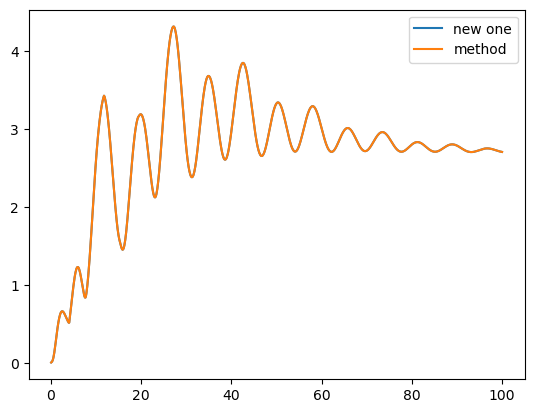

In [200]:
times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

evolution_qfim = jax.vmap(lambda t: m.qfim(true_pars, t, initial_state))(times)


# plt.plot(times, evolution_fim[:, 3, 3])
# plt.plot(times, evolution_qfim[:, 3, 3])


plt.plot(times, jax.vmap(qfim)(times)[:, 0,0], label="new one")
# plt.plot(times, jax.vmap(aux_qfim)(times), label="fun with eigenvals")
# plt.plot(times, jax.vmap(aux_qfim_2)(times)[:, 0,0], label="fun with inverse")
plt.plot(times, evolution_qfim[:, 0,0], label="method")

plt.legend()

In [147]:
def qfim(t):
    evolved_state = m.evolve_initial_state_liouvillian(
        t, m.make_liouvillian(true_pars), initial_state
    )

    eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    partial_rhoi_parameterj = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(
        true_pars.astype(jnp.complex64)
    ).T  # first index is related to the parameter

    partial_rhoi_parameterj = partial_rhoi_parameterj.reshape(-1, 2, 2)

    denominator_lambda_i_plus_lambda_j = jax.vmap(
        lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
    )(eigvals)

    aux_braket = jnp.einsum(
        "im,amn,jn-> ija",
        jnp.conjugate(eigvecs),
        partial_rhoi_parameterj,
        eigvecs,
    )

    aux_braket_with_denominator_product = jnp.einsum(
        "ija,  ij-> ija", aux_braket, denominator_lambda_i_plus_lambda_j
    )
    aux_braket_with_denominator_product_cleaned = jnp.where(
        ~jnp.isinf(aux_braket_with_denominator_product),
        aux_braket_with_denominator_product,
        jnp.zeros(aux_braket_with_denominator_product.shape),
    )

    qfim = 2 * jnp.real(
        jnp.einsum(
            "ija, ijb-> ab",
            jnp.conjugate(aux_braket),
            aux_braket_with_denominator_product_cleaned,
        )
    )
    return qfim

In [23]:
t = times[35]


def qfim_efficient(t):
    evolved_state = m.evolve_initial_state_liouvillian(
        t, m.make_liouvillian(true_pars), initial_state
    )

    eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    partial_rhoi_parameterj = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(true_pars.astype(jnp.complex64))

    superbra_ij_proj = jax.vmap(
        lambda i: jax.vmap(lambda j: dag(vec(jnp.outer(i, dag(j)))))(eigvecs)
    )(
        eigvecs
    )  # [i, j, 4]
    superbra_ij_proj = superbra_ij_proj

    denominator_lambda_i_plus_lambda_j = jax.vmap(
        lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
    )(eigvals)

    denominator_lambda_i_plus_lambda_j = denominator_lambda_i_plus_lambda_j

    yokese = jax.vmap(lambda i: i / denominator_lambda_i_plus_lambda_j)(
        superbra_ij_proj.T
    )  # ()
    yokese_clean = jnp.where(
        ~jnp.isinf(yokese), yokese, jnp.zeros(yokese.shape)
    )

    return jnp.einsum(
        "ijk,ljk-> il", jnp.conjugate(superbra_ij_proj.T), yokese
    )

In [155]:
def aux_qfim_2(t):

    partial_rhoi_parameterj = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(true_pars.astype(jnp.complex64))

    # shape of this is [4, 4] bc of [no_of_values_of_rho, no_of_parameters]

    evolved_state = (
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        )
    )(true_pars)

    middle_product = (
        lambda rho_matrix: jnp.linalg.inv(
            jnp.kron(rho_matrix, jnp.identity(2))
            + jnp.kron(jnp.identity(2), jnp.conjugate(rho_matrix))
        )
    )(evolved_state.reshape(2, 2))

    return jnp.einsum(
        "ij, ik, kl-> jl",
        jnp.conjugate((partial_rhoi_parameterj)),
        2 * middle_product,
        partial_rhoi_parameterj,
    )

In [299]:
t = times[35]


def uff_t(t):
    evolved_state = m.evolve_initial_state_liouvillian(
        t, m.make_liouvillian(true_pars), initial_state
    )

    eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    partial_to_parameter_i_rho_j = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(
        true_pars.astype(jnp.complex64)
    ).T  # now the first index refers to the parameter

    superbra_ij = jax.vmap(
        lambda i: jax.vmap(lambda j: dag(vec(jnp.outer(i, dag(j)))))(eigvecs)
    )(
        eigvecs
    )  # [i, j, 4]
    # superbra_ij_proj = jax.vmap(
    #     lambda i: jax.vmap(lambda j: dag(vec(jnp.outer(i, dag(j)))))(eigvecs)
    # )(
    #     eigvecs
    # )  # [i, j, 4]
    # superbra_ij_proj = superbra_ij_proj

    denominator_lambda_i_plus_lambda_j = jax.vmap(
        lambda i: jax.vmap(lambda j: 1 / (i + j))(eigvals)
    )(
        eigvals
    )  # i, j
    # denominator_lambda_i_plus_lambda_j = denominator_lambda_i_plus_lambda_j

    # partial_to_parameter_i_rho_j[0]

    C_alpha_i_j = jnp.einsum(
        "am, ijm -> aij", partial_to_parameter_i_rho_j, superbra_ij
    )

    C_alpha_i_j_with_denominator = jax.vmap(
        lambda i: i * denominator_lambda_i_plus_lambda_j
    )(C_alpha_i_j)

    qfim_mat = jnp.einsum(
        "aij, bji -> ab",
        C_alpha_i_j,
        jnp.conjugate(C_alpha_i_j_with_denominator),
    )
    return jnp.real(qfim_mat) * 2


# yokese_clean = jnp.where(~jnp.isinf(yokese), yokese, jnp.zeros(yokese.shape))

# return jnp.einsum("ijk,ljk-> il", jnp.conjugate(superbra_ij_proj.T), yokese)

In [148]:
import matplotlib.pyplot as plt

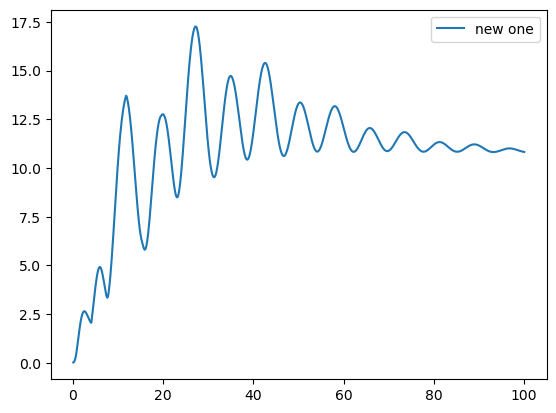

In [162]:
plt.plot(times, jax.vmap(qfim)(times)[:, 2, 2], label="new one")
# plt.plot(times, jax.vmap(aux_qfim)(times), label="fun with eigenvals")
# plt.plot(times, jax.vmap(aux_qfim_2)(times)[:, 2, 2], label="fun with inverse")
plt.legend()

In [ ]:
def aux_qfim_3(t):
    evolved_state = m.evolve_initial_state_liouvillian(
        t, m.make_liouvillian(true_pars), initial_state
    )

    eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    partial_rhoi_parameterj = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(true_pars.astype(jnp.complex64))

    eigvecs

    suma = 0
    for i in range(2):
        for j in range(2):
            braket1 = jnp

            braket = jnp.dot(
                vec(dag(jnp.outer(eigvecs[i], eigvecs[j]))),
                partial_rhoi_parameterj[:, 2],
            )
            value = braket * jnp.conjugate(braket)

            suma = (
                suma + value * 4 * eigvals[i] / (eigvals[i] + eigvals[j]) ** 2
            )
    return suma

In [154]:
def aux_qfim(t):
    evolved_state = m.evolve_initial_state_liouvillian(
        t, m.make_liouvillian(true_pars), initial_state
    )

    eigvals, eigvecs = jnp.linalg.eigh(evolved_state.reshape(2, 2))

    partial_rhoi_parameterj = jax.jacobian(
        lambda particle: m.evolve_initial_state_liouvillian(
            t, m.make_liouvillian(particle), initial_state
        ),
        holomorphic=True,
    )(true_pars.astype(jnp.complex64))

    eigvecs

    suma = 0
    for i in range(2):
        for j in range(2):
            braket = jnp.dot(
                vec(dag(jnp.outer(eigvecs[i], eigvecs[j]))),
                partial_rhoi_parameterj[:, 2],
            )
            value = braket * jnp.conjugate(braket)

            suma = (
                suma + value * 4 * eigvals[i] / (eigvals[i] + eigvals[j]) ** 2
            )
    return suma

/home/antonio/miniconda3/envs/jax/lib/python3.11/site-packages/jax/_src/array.py:377: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


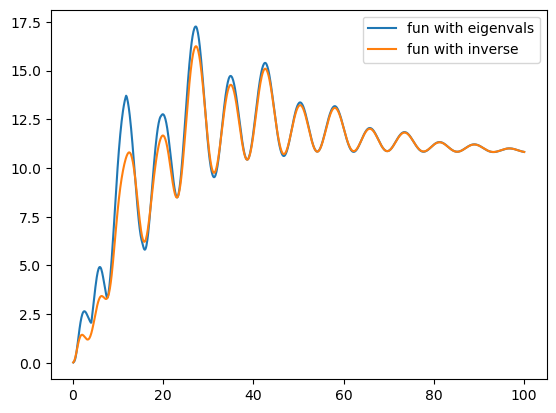

In [78]:
plt.plot(times, jax.vmap(aux_qfim)(times), label="fun with eigenvals")
plt.plot(times, jax.vmap(aux_qfim_2)(times)[:, 2, 2], label="fun with inverse")
plt.legend()

In [29]:
@jit
def aux_fun(n, arr):

    # jnp.where(~jnp.isinf(fim_element), fim_element, 0).sum(axis=0)

    # zeros = jnp.zeros(arr.shape)

    return jnp.array(
        [jnp.where(i < n, arr[i], 0) for i in range(arr.shape[0])]
    ).sum()

    # return jnp.sum(arr[0:n])


aux_fun(3, jnp.linspace(0, 100, 1000))

In [37]:
times = jnp.linspace(0, 100, 1000)

evolved_lkl = jax.vmap(
    lambda t: m.likelihood_particle(true_pars, t, initial_state)
)(times)

evolution_fim = jax.vmap(lambda t: m.fim(true_pars, t, initial_state))(times)

In [57]:
import matplotlib.pyplot as plt

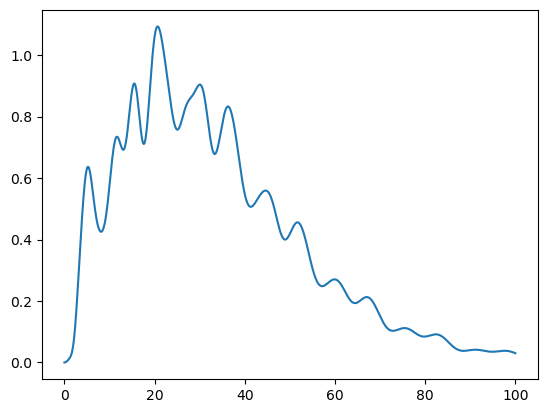

In [43]:
plt.plot(times, evolution_fim[:, 3, 3])